# Ячейка для импортов

In [1]:
import pandas as pd
from string import punctuation
import textacy
import re
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.corpus import stopwords
import torch
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Добыча и обработка данных

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda = device

прочитаем для начала файл, оставив только нужные нам колонки; для экономии памяти сразу определим тип данных нашего таргета

In [3]:
raw = pd.read_csv('Fake.csv', encoding='utf-8', usecols=['title', 'text', 'subject'], dtype={'subject': 'category'})

In [4]:
raw.shape

(23481, 3)

In [5]:
raw.head()

,title,text,subject
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News


In [6]:
raw.tail()

,title,text,subject
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east


что с классами? давайте посчитаем, чтобы иметь на всякий случай в виду, есть ли у нас дисбаланс

In [7]:
raw.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

...есть. Сюрприз-то какой. В сторону одного из классов перекашивает чуть ли не половину данных; два класса из шести закрывают эдак три четверти данных. Плохо, будем знать и что-то с этим делать заранее.

но сначала - закодируем категории таргета и создадим таргет и обучающие данные:

In [8]:
categorical_data = raw.subject.factorize()

In [9]:
with torch.cuda.device(cuda):
    y = categorical_data[0]
    X = raw.title.str.lstrip() + '. ' + raw.text

с чистой совестью сносим прочитанный файл из памяти - она нам очень понадобится

In [10]:
del raw

In [11]:
categories = {subject:cat for cat, subject in enumerate(categorical_data[1])}

In [12]:
categories

{'News': 0,
 'politics': 1,
 'Government News': 2,
 'left-news': 3,
 'US_News': 4,
 'Middle-east': 5}

здесь уже пришло время провести сплит, чтобы последующей обработкой не замарать тестовый набор

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.20, random_state=42)

удаляем предыдущие данные и теперь

In [14]:
del X
del y

здесь нам нужна маленькая функция для очистки данных - она удалит теги, имена пользователей, эмодзи, адреса и вложенные ссылки на видеообъекты; уберем даты, соответствующие каждому комментарию, и лемматизируем оставшееся без стоп-слов и пунктуации

In [15]:
from textacy import preprocessing, extract
preproc = preprocessing.make_pipeline(preprocessing.replace.hashtags,
                                      preprocessing.replace.user_handles,
                                      preprocessing.replace.emojis,
                                      preprocessing.replace.urls
                                     )
def preprocessing(text):
    if '// < ![CDATA' in text:
        text = text.split('// < ![CDATA')[0]
    text = textacy.make_spacy_doc(re.sub(' \w+ \d{2}, \d{4}', ' ', preproc(text.lower())), "en_core_web_sm")
    proc_text = [x.lemma_ for x in extract.basics.words(text, filter_stops=True, filter_punct=True)]
    return proc_text

переберем с помощью этой функции все наши тексты: одновременно будем считать их длину в токенах для показателя максимальной длины и закинем леммы в общий список; чтобы не бояться неадекватных данных, будем выводить индексы каждого нового максимально длинного текста, чтобы можно было его найти и посмотреть вручную

In [16]:
%%time
max_len = 0
known_words = []
train_preprocessed = []
for news in range(len(X_train)):
    news_text = preprocessing(X_train[news])
    known_words.extend(news_text)
    train_preprocessed.append(news_text)
    if len(news_text)>max_len:
        (print(news))
        max_len = len(news_text)

0
1
2
3
4
9
14
43
1352
7503
8505
10356
18374
Wall time: 16min 12s


In [17]:
max_len

4825

собираем словарь слов к индексам для всех слов, встретившихся чаще 5 раз

In [18]:
%%time
word2index = {'UNK': 0}
word2index.update({k:num for num, k in enumerate({key:value for key, value in Counter(known_words).items() if value>1}.keys(), start=1)})

Wall time: 531 ms


и что мы делаем? правильно - удаляем большой список сразу же, как он нам больше не нужен.

In [ ]:
del known_words

для перепроверки сделаем и словарик дешифровки

In [20]:
index2word = {num:k for k, num in word2index.items()}

В статье предлагается взять предобученные вектора из word2vec - этим и займемся

In [21]:
import gensim.downloader as api
vec_model = api.load("word2vec-google-news-300")

In [22]:
api.info("word2vec-google-news-300")

{'num_records': 3000000,
 'file_size': 1743563840,
 'base_dataset': 'Google News (about 100 billion words)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-google-news-300/__init__.py',
 'license': 'not found',
 'parameters': {'dimension': 300},
 'description': "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
 'read_more': ['https://code.google.com/archive/p/word2vec/',
  'https://arxiv.org/abs/1301.3781',
  'https://arxiv.org/abs/1310.4546',
  'https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representations/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F189726%2Frvec

выглядит...красиво. Проверим, работает ли.

In [23]:
vec_model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

где-то здесь я попыталась подгрузить в память куды всю векторную модель сразу и получила от нее леща - 3.5 гб это не шутки, у меня и без того здесь все занято уже. Так что оставляем только те вектора, которые нам встретились в трейне, и надеемся на лучшее

In [24]:
vectors = []
unknown_vector = np.random.uniform(-0.25, 0.25, 300)

for word in word2index.keys():
    if word in vec_model:
        vectors.append(vec_model.get_vector(word))
    else:
        vectors.append(unknown_vector)

vectors = torch.FloatTensor(np.array(vectors))

проверим, не потерялось ли чего.

In [25]:
len(vectors) == len(word2index)

True

In [26]:
vectors.cuda()

tensor([[-0.0947, -0.5117,  0.0581,  ...,  0.3906, -0.0034,  0.2812],
        [-0.0223, -0.0045, -0.1001,  ..., -0.1797, -0.1216, -0.0908],
        [-0.1582, -0.4688, -0.1230,  ...,  0.0283,  0.0432, -0.0986],
        ...,
        [ 0.1930, -0.0553, -0.1547,  ..., -0.2383,  0.0851, -0.2300],
        [ 0.1930, -0.0553, -0.1547,  ..., -0.2383,  0.0851, -0.2300],
        [ 0.1930, -0.0553, -0.1547,  ..., -0.2383,  0.0851, -0.2300]],
       device='cuda:0')

сносим непригодившиеся вектора

del vec_model

что ж, а теперь собираем датасеты; как завещала статья, как паддинги используем неизвестные токены

In [28]:
def dataset_preparation(x_data, data, word2index, maxlen, flag):   
    for text in data:
        if flag == 'train':
            words = text
        elif flag == 'test':
            words = preprocessing(text)
        indexed_words = [word2index[word] if word in word2index else word2index['UNK'] for word in words[:maxlen]]
        x_data.append(indexed_words)
    return x_data
                   
def padding(sequence, pad_index, maxlen):
    #sequence = str
    #pad_index = str
    #maxlen = int
    if len(sequence) < maxlen:
        add_pad = maxlen - len(sequence)
        return sequence+[pad_index]*add_pad
    else:
        return sequence[:maxlen]

датасет собираем по образцу - перекрываем три базовых функции датасета, добавляем последнюю потому, что ее просит штучка, которую мы скоро используем

In [29]:
from torch.utils.data import Dataset, DataLoader
class NewsDataset(Dataset):
    
    def __init__(self, x, y, word2index, maxlen, flag, pad_token='UNK', verbose=True):
        super().__init__()
        self.x_data = []
        self.y_data = y
        self.word2index = word2index
        self.maxlen = maxlen
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        dataset_preparation(self.x_data, x, word2index, maxlen, flag)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        x = padding(x, self.word2index[self.pad_token], self.maxlen)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]
        return x, y
    
    def __len__(self):
        return len(self.x_data)
    
    def get_labels(self):
        return self.y_data

штучка близко...осталось только соорудить сами датасеты...

In [30]:
train_dataset = NewsDataset(x=train_preprocessed, y=y_train, word2index=word2index, maxlen=max_len, flag='train')
test_dataset = NewsDataset(x=X_test, y=y_test, word2index=word2index, maxlen=max_len, flag='test')

и вот мы здесь! эта штука поможет нам для каждого сэмпла выбирать примерно поровну представителей каждого класса, чтобы скомпенсировать наш дисбаланс

In [31]:
from torchsampler import ImbalancedDatasetSampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=32)

проверяем, все ли в порядке.

In [32]:
for i in next(iter(test_loader))[0][0]:
    print(index2word[int(i)])

hillary
cough
discover
secret
keep
cough
video
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
U

In [33]:
for i in next(iter(train_loader))[0][1]:
    print(index2word[int(i)])

third
navy
strike
fighter
jet
ground
navy
claim
money
fix
21st
century
wire
say
defense
news
say
percent
navy
s
f-18
ground
service
attribute
isn
t
money
fix
note
await
plan
maintenance
hold
wait
spare
part
wonder
story
navy
s
fighter
commission
dod
budget
2016
600
billion
dollar
money
spare
part
rt
break
story
ll
find
factor
consider
money
spare
part
factor
include
shore
facility
disrepair
refurbish
retrofit
issue
new
equipment
delay
development
replacement
platform
f-35
compound
decade
war
UNK
percent
navy
s
f
UNK
service
27
percent
major
depot
work
35
percent
simply
await
maintenance
part
defense
news
say
add
53
percent
navy
aircraft
1,700
combat
aircraft
patrol
transport
plane
helicopter
t
UNK
isn
t
money
fix
fleet
s
ship
backlog
ship
need
work
continue
grow
article
say
sub
allegedly
service
literally
year
year
defense
news
reports.the
navy
t
money
service
member
family
change
assignment
$
440
million
need
pay
sailor
accord
publication
service
claim
15
percent
shore
facility
fail
c

ага, все в порядке.

In [34]:
next(iter(train_loader))[1]

tensor([2, 2, 4, 4, 1, 2, 5, 2, 5, 0, 2, 0, 2, 2, 2, 1, 1, 0, 3, 3, 0, 0, 5, 3,
        0, 1, 2, 0, 0, 0, 2, 2])

ух ты, и правда, всех классов более-менее поровну. Продолжаем. Как там у нас с количеством векторов?

In [35]:
vectors.shape

torch.Size([66065, 300])

In [48]:
del train_preprocessed

Кажется, все готово.

# Модель и пайплайн

крафтим на коленке нашу многослойную сетку. Из любопытного тут разве что то, что я добавила туда слой батч-нормализации, а в векторах теперь вектора из генсима. Попробуем также использовать подтекающую РеЛУ - у меня кошмарно переобучается модель, похоже.

In [49]:
class CLSTM_model(torch.nn.Module):
    
    def __init__(self, embedding_dim, num_classes, vectors, filters, window_len,
                 lstm_memory_dim, dropout_rate,
                 dropout_flag, max_length):
        super().__init__()
        self.dropout_flag = dropout_flag
        self.dropout = nn.Dropout(p=dropout_rate)
        self.sigmoid = nn.Sigmoid()
        self.embedding = torch.nn.Embedding.from_pretrained(vectors, padding_idx=0)
        self.conv = torch.nn.Conv1d(embedding_dim, filters, kernel_size=window_len, padding='valid')
        self.LSTM = torch.nn.LSTM(input_size=filters, 
                                  hidden_size=lstm_memory_dim, proj_size=6,
                                  num_layers=1, batch_first=True)
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.batchnorm = nn.BatchNorm1d(filters)
        self.relu = torch.nn.LeakyReLU()
 
    def forward(self, x):
        x_emb = self.embedding(x)
        if self.dropout_flag == 'before':
            x_emb = self.dropout(x_emb)
        x_emb = x_emb.transpose(1,2)
        cnn_res = self.relu(self.batchnorm(self.conv(x_emb)))
        to_lstm = cnn_res.transpose(1, 2)
        _, (x, _) = self.LSTM(to_lstm)
        x.squeeze_(0)
        if self.dropout_flag == 'after':           
            x = self.dropout(x)
        logits = self.softmax(x) #l2?
        return logits

А вот и пайплайн! В модель мы можем передавать количество фильтров и их размер, память лстм, размерность вектора эмбеддинга, номер классов, место и частота дропаута; в следующую функцию можно передавать модель и количество эпох обучения

In [64]:
def try_model(epochs, model):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.001, weight_decay=0.001)
    all_trains = []
    all_tests = []
    losses = []
    test_accuracy = []

    for n_epoch in range(epochs):

        train_losses = []
        test_losses = []
        test_targets = []
        test_pred_class = []

        progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        model.train()

        for x, y in train_loader:
            x = x.to(cuda)
            y = y.to(cuda)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            optimizer.step()
            train_losses.append(loss.item())
            losses.append(loss.item())
            progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

        model.eval()

        test_targets = []
        test_pred_class = []

        for x, y in test_loader:
            x = x.to(cuda)
            y = y

            with torch.no_grad():
                pred = model(x).cpu()
                test_targets.append(y.numpy())
                test_pred_class.append(np.argmax(pred.cpu(), axis=1))
                loss = criterion(pred, y)
                test_losses.append(loss.item())

        mean_test_loss = np.mean(test_losses)
        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        accuracy = accuracy_score(test_targets, test_pred_class)

        test_accuracy.append(accuracy)
        all_trains.append(np.mean(train_losses))
        all_tests.append(mean_test_loss)

        print()
        print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

        print('Accuracy test - {:.3f}'.format(accuracy))

    plt.figure(figsize=(10,5))
    plt.title("Train and test Loss")
    plt.plot(all_tests,label="test")
    plt.plot(all_trains,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    #return {'accuracy': accuracy, }

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [04:55<00:00, 63.67it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [04:52<00:00, 64.16it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.790
Accuracy test - 0.286


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [04:53<00:00, 63.99it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.191


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [04:53<00:00, 64.09it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.388


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [04:52<00:00, 64.22it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.790
Accuracy test - 0.191


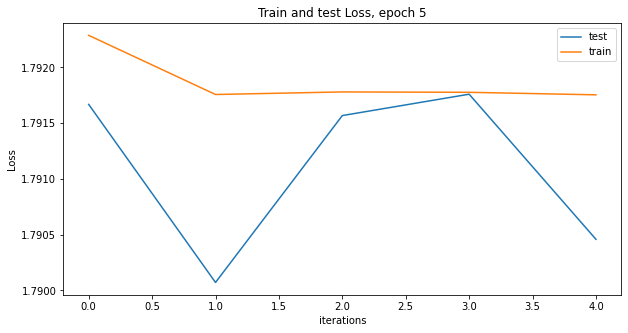

In [51]:
model_clstm = try_model(5, CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=300, window_len=3, lstm_memory_dim=300,
                         dropout_rate=0.5, dropout_flag='after', max_length=max_len).cuda())

In [57]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

# Эксперименты с конфигурацией

в статье были описаны следующие вариации модели: размер фильтра (2, 3, 4), положение дропаута (перед КНН или после ЛСТМ), размерности памяти ЛСТМ и количество фильтров (оба 300 или 150). Перепробуем их все.

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.01it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.795
Accuracy test - 0.191


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.86it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.191


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.07it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.034


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.81it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.286


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.00it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


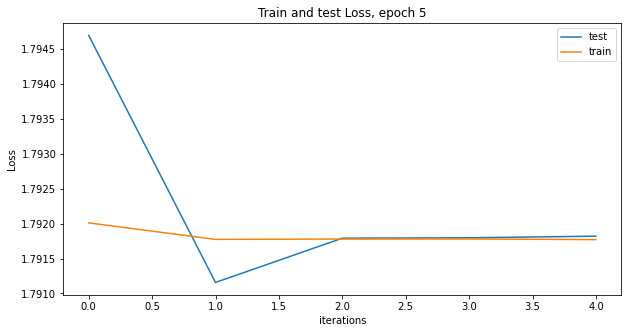

In [58]:
model_1 = CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=150, window_len=3, lstm_memory_dim=150,
                         dropout_rate=0.5, dropout_flag='after', max_length=max_len).cuda()
try_model(5, model_1)

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.52it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.793
Accuracy test - 0.034


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [03:11<00:00, 98.34it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.067


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [03:11<00:00, 98.34it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.191


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [03:11<00:00, 98.17it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.388


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [03:11<00:00, 98.24it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.788
Accuracy test - 0.388


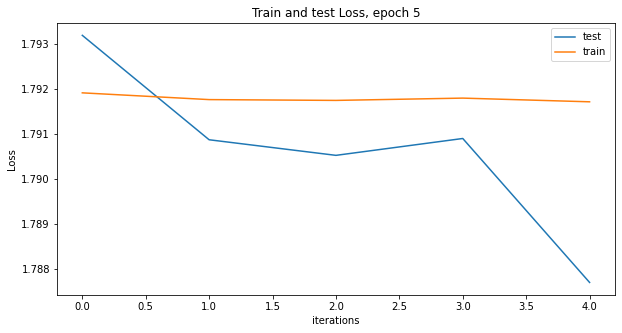

In [60]:
model_2 = CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=150, window_len=4, lstm_memory_dim=150,
                         dropout_rate=0.5, dropout_flag='after', max_length=max_len).cuda()
try_model(5, model_2)

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [04:44<00:00, 66.01it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.795
Accuracy test - 0.034


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [04:44<00:00, 65.96it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [04:44<00:00, 66.00it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.388


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [04:44<00:00, 66.12it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.034


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [04:44<00:00, 66.04it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.286


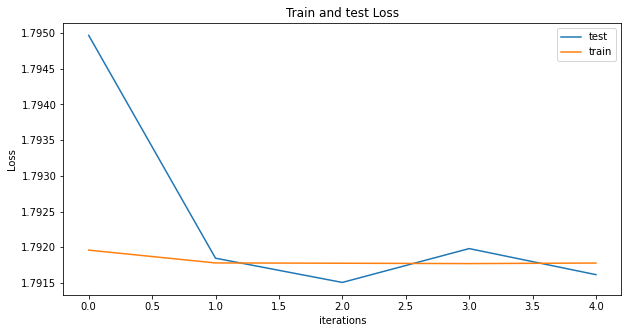

In [63]:
model_3 = CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=300, window_len=2, lstm_memory_dim=300,
                         dropout_rate=0.5, dropout_flag='after', max_length=max_len).cuda()
try_model(5, model_3)

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.52it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.796
Accuracy test - 0.034


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.43it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.388


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.43it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.388


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.39it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [03:10<00:00, 98.41it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.388


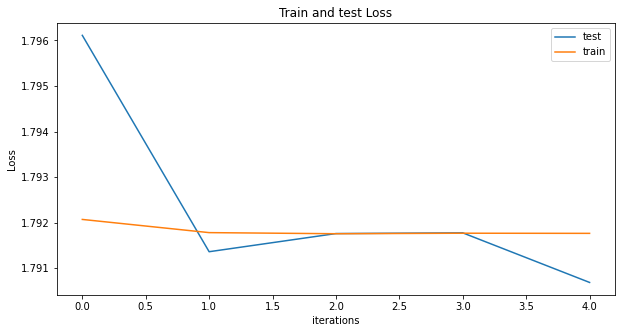

In [65]:
model_4 = CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=150, window_len=3, lstm_memory_dim=150,
                         dropout_rate=0.5, dropout_flag='before', max_length=max_len).cuda()
try_model(5, model_4)

попробуем сделать кое-что другое - изменим предельную длину:

Epoch 1: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.03it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.790
Accuracy test - 0.286


Epoch 2: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.07it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.191


Epoch 3: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 99.15it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


Epoch 4: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 98.90it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.792
Accuracy test - 0.067


Epoch 5: 100%|██████████████████████████████████████████████████| 18784/18784 [03:09<00:00, 98.93it/s, train_loss=1.79]



Losses: train - 1.792, test - 1.791
Accuracy test - 0.388


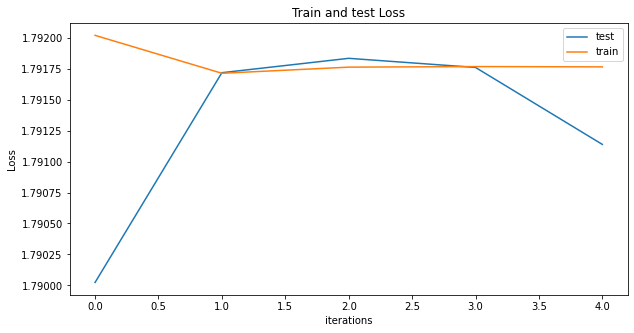

In [66]:
model_5 = CLSTM_model(embedding_dim=300, num_classes=6, vectors=vectors, filters=150, window_len=3, lstm_memory_dim=150,
                         dropout_rate=0.5, dropout_flag='after', max_length=1000).cuda()
try_model(5, model_5)

что ж, это я дурак или лыжи не едут? А именно - что-то модели...они вообще обучаются? Что у них с графиками лоссов?

приличная кривая лосса (хотя бы на тесте) только у модели 2 и 4; на трейн и взглянуть страшно. Гипотеза: кое-кто залажал с обучением, и то, что мы видим теперь - хорошая такая картина отсутствия обучения вообще. 
Уточнение гипотезы: неплохая вероятность того, что секрет кроется там, где мне пришлось попрыгать между девайсами графической памяти и перегонять данные туда-сюда. Контртезис: совершенно нет времени до дедлайна, чтобы все это исследовать, так что примем это как данность - но я буду продолжать исследовать и апдейтну репозиторий, если найду ответ.
А пока что, резюме произошедшего:
+ дропаут после лстм обычно лучше дропаута перед кнн: возможно, это последствие работы с и так предобученными на вполне универсальном датасете эмбеддингами
+ для предотвращения оверфита можно использовать обрезку градиента, нормализацию батчей, нормализацию исходных данных, увеличение размера батча, правильный подбор скорости обучения и исправление дисбаланса классов; судя по тому, что у меня ничего из этого дело не исправило...дело у меня все же в каких-то багах моего же кода - ох кажется мне, что надо прогнать все то же самое, но на цпу...раз уж трейн вообще не меняется, значит, где-то в трейне косяк с обучением
+ ага, авторы статьи были правы в том, что размер фильтра 3 лучше, чем 2 или 4 - он определенно и быстрее прогоняется, и эффективнее работает
+ уменьшение максимальной длины приводит к стойкому падению точности на тесте: оверфит при нехватке данных для обучения?

для того, чтобы разобраться получше, посмотрим на выдачу каждой из моделей:

In [85]:
test_task, test_target = next(iter(test_loader))
print(test_target)

tensor([1, 1, 3, 0, 0, 0, 0, 3, 1, 0, 1, 5, 0, 1, 0, 2, 3, 0, 0, 0, 3, 0, 1, 0,
        0, 4, 0, 0, 2, 1, 0, 0])


In [91]:
torch.argmax(model_2(test_task.cuda()), axis=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [109]:
#тут у меня совсем кончилась память на куде
torch.argmax(model_4.cpu()(test_task), axis=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

мы...просто каждая обучились выдавать экземпляры одного класса. Переобуч? Гипотеза: слишком много информации или слишком глубокая датасет; мы взяли не тот предобученный вариант ворд2века?